##Script to 3D Pipeline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Initial setup

In [2]:
!pip install SentencePiece #restart runtime after running this cell first time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 5.1 MB/s 


In [3]:
!pip install transformers==2.9.0
!pip install pytorch_lightning==0.7.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 635 kB 5.1 MB/s 
     |████████████████████████████████| 880 kB 44.2 MB/s 
     |████████████████████████████████| 5.6 MB 32.3 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=01f8273031c70004eaadb033ae9ac77a699a594e91751494ff03b9c99f241d12
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 233 kB 4.8 MB/s 
     |████████████████████████████████| 829 kB 9.0 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=59543ae924defc3396ae26dad55b40253657d3d322ebb6fc5bba99038d101806
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32

In [4]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
INFO:transformers.file_utils:PyTorch version 1.11.0+cu113 available.
INFO:transformers.file_utils:TensorFlow version 2.8.2 available.


In [5]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [6]:
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    self.hparams = hparams
    
    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
  
  def is_logger(self):
    return self.trainer.proc_rank <= 0
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        lm_labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    if self.trainer.use_tpu:
      xm.optimizer_step(optimizer)
    else:
      optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparams)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="val", args=self.hparams)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [7]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

In [8]:
args_dict = dict(
    data_dir="", # path for data files
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=512,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=2,
    gradient_accumulation_steps=16,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)

In [9]:
!wget https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
!wget https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt
!wget https://www.dropbox.com/s/2mzialpsgf9k5l3/val.txt

--2022-06-18 07:40:15--  https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ikkqxfdbdec3fuj/test.txt [following]
--2022-06-18 07:40:15--  https://www.dropbox.com/s/raw/ikkqxfdbdec3fuj/test.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3fe537b4dc38cdb2f083e14efd.dl.dropboxusercontent.com/cd/0/inline/Bna7oXovooq12Q8ocLF0zmT2lc4RmM5F4hQzcuju3ZDYB3PDsF1FcwoRcXctVUN0TYQLw-9MC1UjCazjpKW7LDkXQPREOufKbQl5Sc9aKbnU8xPd1QQrHuNNjxe7L5mMxuo4fBVdFs4EDoXja918fHISgO6wCX9nBdOXWBW2LGeOVA/file# [following]
--2022-06-18 07:40:16--  https://uc3fe537b4dc38cdb2f083e14efd.dl.dropboxusercontent.com/cd/0/inline/Bna7oXovooq12Q8ocLF0zmT2lc4RmM5F4hQzcuju3ZDYB3PDsF1FcwoRcXctVUN0TYQLw-9MC1UjCazj

In [10]:
!mkdir emotion_data
!mv *.txt emotion_data

In [11]:
train_path = "emotion_data/train.txt"
test_path = "emotion_data/test.txt"
val_path = "emotion_data/val.txt"

## emotion labels
label2int = {
  "sadness": 0,
  "joy": 1,
  "love": 2,
  "anger": 3,
  "fear": 4,
  "surprise": 5
}

In [12]:
data = pd.read_csv(train_path, sep=";", header=None, names=['text', 'emotion'],
                               engine="python")

In [13]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')

INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmp6c1bcq64


Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model in cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f


In [14]:
emotions = [ "sadness", "joy", "love", "anger", "fear", "surprise"]

In [15]:
class EmotionDataset(Dataset):
  def __init__(self, tokenizer, data_dir, type_path,  max_len=512, data_override=[]):
    self.path = os.path.join(data_dir, type_path + '.txt')

    self.data_column = "text"
    self.class_column = "emotion"
    if (len(data_override)==0):
      self.data = pd.read_csv(self.path, sep=";", header=None, names=[self.data_column, self.class_column],
                            engine="python")
      print(self.data)
    else:
      with open("temp.csv","w") as f:
        lines = data_override
        # print(lines)
        for line in lines:
          f.write(line+";test\n")
      with open("temp.csv","r") as f:
        self.data = pd.read_csv("temp.csv", sep=";", header=None, names=[self.data_column, self.class_column],
                            engine="python")
        print(self.data)
    
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []

    self._build()
  
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
  
  def _build(self):
    for idx in range(len(self.data)):
      input_, target = self.data.loc[idx, self.data_column], self.data.loc[idx, self.class_column]      
      
      input_ = input_ + ' </s>'
      target = target + " </s>"

       # tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
      )
       # tokenize targets
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target], max_length=2, pad_to_max_length=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

In [16]:
dataset = EmotionDataset(tokenizer, 'emotion_data', 'val', 512)

                                                   text  emotion
0     im feeling quite sad and sorry for myself but ...  sadness
1     i feel like i am still looking at a blank canv...  sadness
2                        i feel like a faithful servant     love
3                     i am just feeling cranky and blue    anger
4     i can have for a treat or if i am feeling festive      joy
...                                                 ...      ...
1995  im having ssa examination tomorrow in the morn...  sadness
1996  i constantly worry about their fight against n...      joy
1997  i feel its important to share this info for th...      joy
1998  i truly feel that if you are passionate enough...      joy
1999  i feel like i just wanna buy any cute make up ...      joy

[2000 rows x 2 columns]


In [17]:
!mkdir -p t5_emotion

In [18]:
## Copy the file here and create dir called checkpoint_folder. Store in that
## File link: https://drive.google.com/file/d/16KIG-OcJN4LypZtXrWrouiv1KrDB6Mu-/view?usp=sharing

In [19]:
import os
import shutil

In [20]:
if os.path.exists('/content/checkpoint_folder'):
    shutil.rmtree('/content/checkpoint_folder')
os.mkdir('/content/checkpoint_folder/')
os.chdir('/content/checkpoint_folder/')

In [21]:
!gdown  https://drive.google.com/uc?id=16KIG-OcJN4LypZtXrWrouiv1KrDB6Mu-

Downloading...
From: https://drive.google.com/uc?id=16KIG-OcJN4LypZtXrWrouiv1KrDB6Mu-
To: /content/checkpoint_folder/checkpointepoch=1.ckpt
100% 2.68G/2.68G [00:14<00:00, 188MB/s]


In [22]:
import textwrap
new_model = T5FineTuner.load_from_checkpoint("/content/checkpoint_folder/checkpointepoch=1.ckpt").cuda()

INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmp7e7j1r8l


Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json in cache at /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json from cache at /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:transformers.configuration_utils:Model config T5Config {
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id"

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://cdn.huggingface.co/t5-base-pytorch_model.bin in cache at /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa
INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/t5-base-pytorch_model.bin from cache at /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa
INFO:transformers.modeling_utils:Weights of T5ForConditionalGeneration not initialized from pretrained model: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight']
INFO:transformers.tokenization_utils:loading

#Tedigan


In [23]:

# os.chdir('/content')
CODE_DIR = '/content/gdrive/MyDrive/courses/CS275/TediGAN'
if not os.path.exists(CODE_DIR):
  !git clone https://github.com/weihaox/TediGAN.git $CODE_DIR
os.chdir(CODE_DIR)
MODEL_DIR = os.path.join('base', 'models', 'pretrain')
os.makedirs(MODEL_DIR, exist_ok=True)

# !pip install ftfy regex tqdm
# !pip install git+https://github.com/openai/CLIP.git

# download pretrained stylegan and encoder
!wget https://mycuhk-my.sharepoint.com/:u:/g/personal/1155082926_link_cuhk_edu_hk/EXqix_JIEgtLl1FXI4uCkr8B5GPaiJyiLXL6cFbdcIKqEA?e=WYesel\&download\=1 -O $MODEL_DIR/styleganinv_ffhq256_encoder.pth  --quiet
!wget https://mycuhk-my.sharepoint.com/:u:/g/personal/1155082926_link_cuhk_edu_hk/EbuzMQ3ZLl1AqvKJzeeBq7IBoQD-C1LfMIC8USlmOMPt3Q?e=CMXn8W\&download\=1 -O $MODEL_DIR/styleganinv_ffhq256_generator.pth  --quiet
!wget https://mycuhk-my.sharepoint.com/:u:/g/personal/1155082926_link_cuhk_edu_hk/EQJUz9DInbxEnp0aomkGGzAB5b3ZZbtsOA-TXct9E4ONqA?e=smtO0T\&download\=1 -O $MODEL_DIR/vgg16.pth  --quiet

!nvidia-smi
!pip install -r requirements.txt

Cloning into '/content/gdrive/MyDrive/courses/CS275/TediGAN'...
remote: Enumerating objects: 262, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 262 (delta 20), reused 18 (delta 18), pack-reused 236
Receiving objects: 100% (262/262), 17.67 MiB | 37.69 MiB/s, done.
Resolving deltas: 100% (101/101), done.
Sat Jun 18 07:42:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 000

# Inputs


In [24]:
os.chdir('/content/gdrive/MyDrive/courses/CS275/TediGAN/base/examples/')

In [25]:
from google.colab import files
import matplotlib.pyplot as plt
uploaded = files.upload()

Saving img1.png to img1.png


In [26]:
gender = 'He'
#inputs = ["I am very happy because my exam went well"]
#inputs = ["My phone was stolen, it fills me with anger"]
inputs = ["Sometimes dogs on the road scare me"]

#Processing Emotion and Face Generation

In [27]:
 #Enter as many inputs
dataset = EmotionDataset(tokenizer, 'emotion_data', 'test', 512, data_override = inputs)
loader = DataLoader(dataset, batch_size=32, num_workers=4)
it = iter(loader)
batch = next(it)
batch["source_ids"].shape
outs = new_model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)
dec = [tokenizer.decode(ids) for ids in outs] #Outputs are in this line
# texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
# for i in range(len(inputs)):
#     c = texts[i]
#     lines = textwrap.wrap("text:\n%s\n" % c, width=100)
#     #print("\n".join(lines))
#     # print("\nActual sentiment: %s" % targets[i])
#     #print("predicted sentiment: %s" % dec[i])
#     #print("=====================================================================\n")
nlp1 = dec[0] # t5 output
print("Emotion detected is ", nlp1)

                                  text emotion
0  Sometimes dogs on the road scare me    test


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  #                main process                              ||


Emotion detected is  fear


In [28]:
os.chdir('/content/gdrive/MyDrive/courses/CS275/TediGAN/base/')
%ls

examples/  invert.py  models/  streamlit_app.py  utils/


In [29]:
#Directly load model from checkpoint and use
#In case model changes, replace path below with file path

import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import os
emotion = nlp1
descr_dict = {"joy":["The person is smiling","The person is smiling","The person is smiling","The person is smiling"],
              "sadness":['The person is crying and bags under eyes' ,'The person is crying and bags under eyes' ,"The person is crying with arched eyebrows and narrow lips","The person is crying with arched eyebrows and narrow lips"],
              "anger":['The person is angry and narrow lips','The person is angry and narrow lips',"The person is angry","The person is angry"],
              "love":['The person is in love, smiling and arched eyebrows','The person is in love, smiling and narrow lips','The person is in love, smiling and narrow eyes','The person is smiling and narrow eyes'],
              "fear":['The person is afraid, has mouth slightly open and big eyes','The person is afraid, has mouth slightly open and big eyes','The person is afraid, has big eyes and smiling and sad' ,'The person is afraid, has big eyes and smiling and sad'  ],
              "surprise":['The person is surprised, smiling and mouth open and big eyes','The person is surprised, smiling and big eyes','The person is surprised, smiling and big eyes','The person is smiling and big eyes' ]}
og_dict = {"joy":"The person is happy","sadness":"The person is sad","anger":"The person is angry","love":"The person is in love","fear":"The person is afraid","surprise":"The person is surprised"}
clip_rate_list = [3.0,2.5,2.0,1.5]
iter_list = [200,100,100,100]
show_orig=True
image_path = 'examples/' +list(uploaded.keys())[0]  #MAKE SURE THE CORRESPONDING image is in your examples folder
model_name = "styleganinv_ffhq256"
img_name = image_path[image_path.index("/")+1:image_path.index(".")]

impath_list = [image_path,"results/inversion/test/"+img_name+"_inv.png", "results/inversion/test/"+img_name+"_inv_inv.png", "results/inversion/test/"+img_name+"_inv_inv_inv.png" ]
desc_list = descr_dict[emotion]



In [30]:
initial = image_path
final = "results/inversion/test/"+img_name+"_inv_inv_inv_enc.png"
for i in range(len(desc_list)):
  desc = desc_list[i].replace("The person",gender)
  clip = clip_rate_list[i]
  iterations = iter_list[i]
  command = "python invert.py --image_path={} --model_name={} --mode='man' --description=f'{}' --learning_rate=0.01 --num_iterations={} --loss_weight_clip={}".format(impath_list[i], model_name, desc, iterations, clip)
  print(command)
  os.system(command)
result_image = cv2.imread(final)  #Output image is HERE

og_desc = og_dict[emotion].replace("The person",gender)
command = "python invert.py --image_path={} --model_name={} --mode='man' --description=f'{}' --learning_rate=0.01 --num_iterations={} --loss_weight_clip={}".format(image_path, model_name, og_desc, 200, 2.0)
print(command)
os.system(command)
og_image = cv2.imread("results/inversion/test/"+img_name+"_inv.png")

python invert.py --image_path=examples/img1.png --model_name=styleganinv_ffhq256 --mode='man' --description=f'He is afraid, has mouth slightly open and big eyes' --learning_rate=0.01 --num_iterations=200 --loss_weight_clip=3.0
python invert.py --image_path=results/inversion/test/img1_inv.png --model_name=styleganinv_ffhq256 --mode='man' --description=f'He is afraid, has mouth slightly open and big eyes' --learning_rate=0.01 --num_iterations=100 --loss_weight_clip=2.5
python invert.py --image_path=results/inversion/test/img1_inv_inv.png --model_name=styleganinv_ffhq256 --mode='man' --description=f'He is afraid, has big eyes and smiling and sad' --learning_rate=0.01 --num_iterations=100 --loss_weight_clip=2.0
python invert.py --image_path=results/inversion/test/img1_inv_inv_inv.png --model_name=styleganinv_ffhq256 --mode='man' --description=f'He is afraid, has big eyes and smiling and sad' --learning_rate=0.01 --num_iterations=100 --loss_weight_clip=1.5
python invert.py --image_path=exam

In [31]:
os.listdir('/content/gdrive/MyDrive/courses/CS275/TediGAN/base/results/inversion/test')

['img1_inv_inv_enc.png',
 'img1_ori.png',
 'img1_inv_ori.png',
 'img1_inv.png',
 'img1_inv_inv_inv_ori.png',
 'img1_inv_inv_inv.png',
 'img1_inv_inv_inv_enc.png',
 'img1_enc.png',
 'img1_inv_enc.png',
 'img1_inv_inv_ori.png',
 'img1_inv_inv.png',
 'img1_inv_inv_inv_inv.png']

#Output of Tedigan

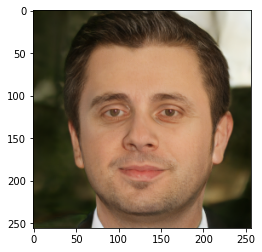

In [32]:
result_image=plt.imread(final)
og_image = plt.imread("results/inversion/test/"+img_name+"_inv.png")
plt.imshow(result_image)


# DECA

In [33]:
os.chdir('/content')

In [34]:
!git clone https://github.com/YadiraF/DECA


Cloning into 'DECA'...
remote: Enumerating objects: 422, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 422 (delta 15), reused 15 (delta 7), pack-reused 385
Receiving objects: 100% (422/422), 23.00 MiB | 36.01 MiB/s, done.
Resolving deltas: 100% (168/168), done.


In [35]:
os.chdir('/content/DECA')
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.7 MB 5.5 MB/s 
     |████████████████████████████████| 50 kB 8.2 MB/s 
     |████████████████████████████████| 60.9 MB 1.3 MB/s 
     |████████████████████████████████| 274 kB 70.1 MB/s 
     |████████████████████████████████| 748.8 MB 18 kB/s 
     |████████████████████████████████| 5.9 MB 22.1 MB/s 
     |████████████████████████████████| 195 kB 67.6 MB/s 
     |████████████████████████████████| 108 kB 67.2 MB/s 
     |████████████████████████████████| 50 kB 5.1 MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.1.1-cp37-cp37m-linux_x86_64.whl size=44114 sha256=7398591c7117ffa162a5fa766d86f66ef94259a264dfd3715f321cdda15bc3cb
  Stored in directory: /root/.cache/pip/wheels/6f/a6/e1/6ab3225ed36801d672de2a9a8b04b30e4b1ac9efe3fa31c7a1
  Created wheel for chumpy: filename=chumpy-0.70-py3-none-any.whl size=58285 sha256=f51ffb7754daee0665003b883f4de1d

In [36]:
#import torch, torchvision
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Cuda availability : " + str(device))

Cuda availability : cuda


# BFM to FLAME

In [37]:
os.chdir('/content')

In [38]:
!git clone https://github.com/TimoBolkart/BFM_to_FLAME.git

Cloning into 'BFM_to_FLAME'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 97 (delta 17), reused 13 (delta 13), pack-reused 78
Unpacking objects: 100% (97/97), done.


In [39]:
!pip install numpy==1.19.4
!pip install h5py==3.1.0
!pip install chumpy==0.70 
!pip install opencv-python==4.4.0.46

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.5 MB 94 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 0.20.2 requires pandas>=1.1, but you have pandas 1.0.1 which is incompatible.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.4 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.6.0 which is incompatible.
tensorflow 2.8.2+zzzcolab20220527125636 requires numpy>=1.20, but you have numpy 1.19.4 which is incompatible.
google-colab 1.0.0 requires ipykernel~=4.10, but you have ipykernel 5.5.6 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0,

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.5 MB 108 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.6.0.66
    Uninstalling opencv-python-4.6.0.66:
      Successfully uninstalled opencv-python-4.6.0.66
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [40]:
os.chdir('/content/DECA/data')
!gdown https://drive.google.com/u/1/uc?id=1AZxucPN_ahOBuDb415ZBoR0wmjZfOCK0&export=download

Downloading...
From: https://drive.google.com/u/1/uc?id=1AZxucPN_ahOBuDb415ZBoR0wmjZfOCK0
To: /content/DECA/data/generic_model.pkl
100% 53.0M/53.0M [00:00<00:00, 121MB/s] 


In [41]:
os.chdir('/content/DECA/data')
!gdown https://drive.google.com/u/0/uc?id=1rp8kdyLPvErw2dTmqtjISRVvQLj6Yzje&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1rp8kdyLPvErw2dTmqtjISRVvQLj6Yzje
To: /content/DECA/data/deca_model.tar
100% 434M/434M [00:01<00:00, 219MB/s]


In [42]:
os.chdir('/content/BFM_to_FLAME/model/')
!gdown https://drive.google.com/u/1/uc?id=1DuFWpduT-jDtRywl9TirxzdQTqHuPtph&export=download
#!cp model2017-1_bfm_nomouth.h5 BFM_to_FLAME/model/

Downloading...
From: https://drive.google.com/u/1/uc?id=1DuFWpduT-jDtRywl9TirxzdQTqHuPtph
To: /content/BFM_to_FLAME/model/model2017-1_bfm_nomouth.h5
100% 325M/325M [00:01<00:00, 184MB/s]


In [43]:
os.chdir('/content/BFM_to_FLAME/data/')
!gdown http://files.is.tue.mpg.de/tbolkart/FLAME/mask_inpainting.npz
#!cp mask_inpainting.npz BFM_to_FLAME/data/

Downloading...
From: http://files.is.tue.mpg.de/tbolkart/FLAME/mask_inpainting.npz
To: /content/BFM_to_FLAME/data/mask_inpainting.npz
100% 78.6M/78.6M [00:03<00:00, 23.8MB/s]


In [44]:
os.chdir('/content/BFM_to_FLAME/')

In [45]:
!python3 col_to_tex.py

Conversion started......
tcmalloc: large alloc 1251999744 bytes == 0x4acaa000 @  0x7fd27509a001 0x7fd26915a54f 0x7fd2691aab08 0x7fd2691aec07 0x7fd26924d063 0x593784 0x548c51 0x51566f 0x593dd7 0x5118f8 0x593dd7 0x5118f8 0x549576 0x604173 0x5f5506 0x5f8c6c 0x5f9206 0x64faf2 0x64fc4e 0x7fd274c95c87 0x5b621a
Conversion finished


In [46]:
os.chdir('../')

In [47]:
!cp BFM_to_FLAME/output/FLAME_albedo_from_BFM.npz DECA/data/

#DECA output

In [48]:
if os.path.exists('/content/DECA/TestSamples/check'):
    shutil.rmtree('/content/DECA/TestSamples/check')
os.mkdir('/content/DECA/TestSamples/check')
os.chdir('/content/DECA/TestSamples/check')
final = '/content/gdrive/MyDrive/courses/CS275/TediGAN/base/'+final
shutil.copy(final,'/content/DECA/TestSamples/check' )

'/content/DECA/TestSamples/check/img1_inv_inv_inv_enc.png'

In [49]:
os.chdir('/content/DECA/')

In [50]:
!python3 demos/demo_reconstruct.py -i TestSamples/check --saveDepth True --saveObj True --useTex True

Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth
100% 85.7M/85.7M [00:04<00:00, 18.9MB/s]
Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4_1.6-c827573f02.zip" to /root/.cache/torch/hub/checkpoints/2DFAN4_1.6-c827573f02.zip
100% 91.9M/91.9M [00:04<00:00, 21.3MB/s]
creating the FLAME Decoder
tcmalloc: large alloc 1251999744 bytes == 0x8c2ec000 @  0x7f5fb2ccc1e7 0x7f5fa6d8e46e 0x7f5fa6ddec2b 0x7f5fa6d91ce8 0x5947d6 0x548cc1 0x5127f1 0x549576 0x593fce 0x548ae9 0x5127f1 0x4bc98a 0x533274 0x4d3969 0x512147 0x549e0e 0x4bcb19 0x532b86 0x594a96 0x515600 0x549e0e 0x593fce 0x548ae9 0x51566f 0x549e0e 0x4bca8a 0x532b86 0x594a96 0x548cc1 0x5127f1 0x593dd7
trained model found. load /content/DECA/data/deca_model.tar
  0% 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_cor

In [51]:
image_name = final.split('/')[-1]
image_name = image_name[0:len(image_name)-4]
pt = '/content/DECA/TestSamples/examples/results/'+ image_name
o_pt=shutil.make_archive("output", 'zip', pt)
shutil.copy(o_pt, '/content/')

'/content/output.zip'

In [52]:
files.download('/content/output.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>